# Phần 1. Tổng quan tập dữ liệu

1.1 Nhập các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy import stats
from scipy.stats.mstats import winsorize
import scipy.cluster.hierarchy as hcluster
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
import matplotlib.patches as ptch
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")

1.2 Nhập tập dữ liệu

In [2]:
df = pd.read_csv('country_data.csv')

1.3 Tìm hiểu dữ liệu

1.3.1 In ra 5 dòng đầu của tập dữ liệu

In [3]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


1.3.2 Thông tin tập dữ liệu

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


1.3.3 Kiểm tra số lượng giá trị duy nhất trong mỗi cột

In [5]:
dict = {}
for i in list(df.columns):
    dict[i] = df[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
country,167
child_mort,139
exports,147
health,147
imports,151
income,156
inflation,156
life_expec,127
total_fer,138
gdpp,157


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


# Phần 2: Tiền xử lý dữ liệu

2.1 Kiểm tra và xử lý những giá trị trùng lặp

In [7]:
# Kiểm tra các giá trị trùng lặp
df.duplicated().sum()

0

2.2 Kiểm tra giá trị NaN

In [8]:
# Kiểm tra giá trị NaN
df.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

2.3 Giá trị ngoại lệ

2.3.1 Kiểm tra giá trị ngoại lệ

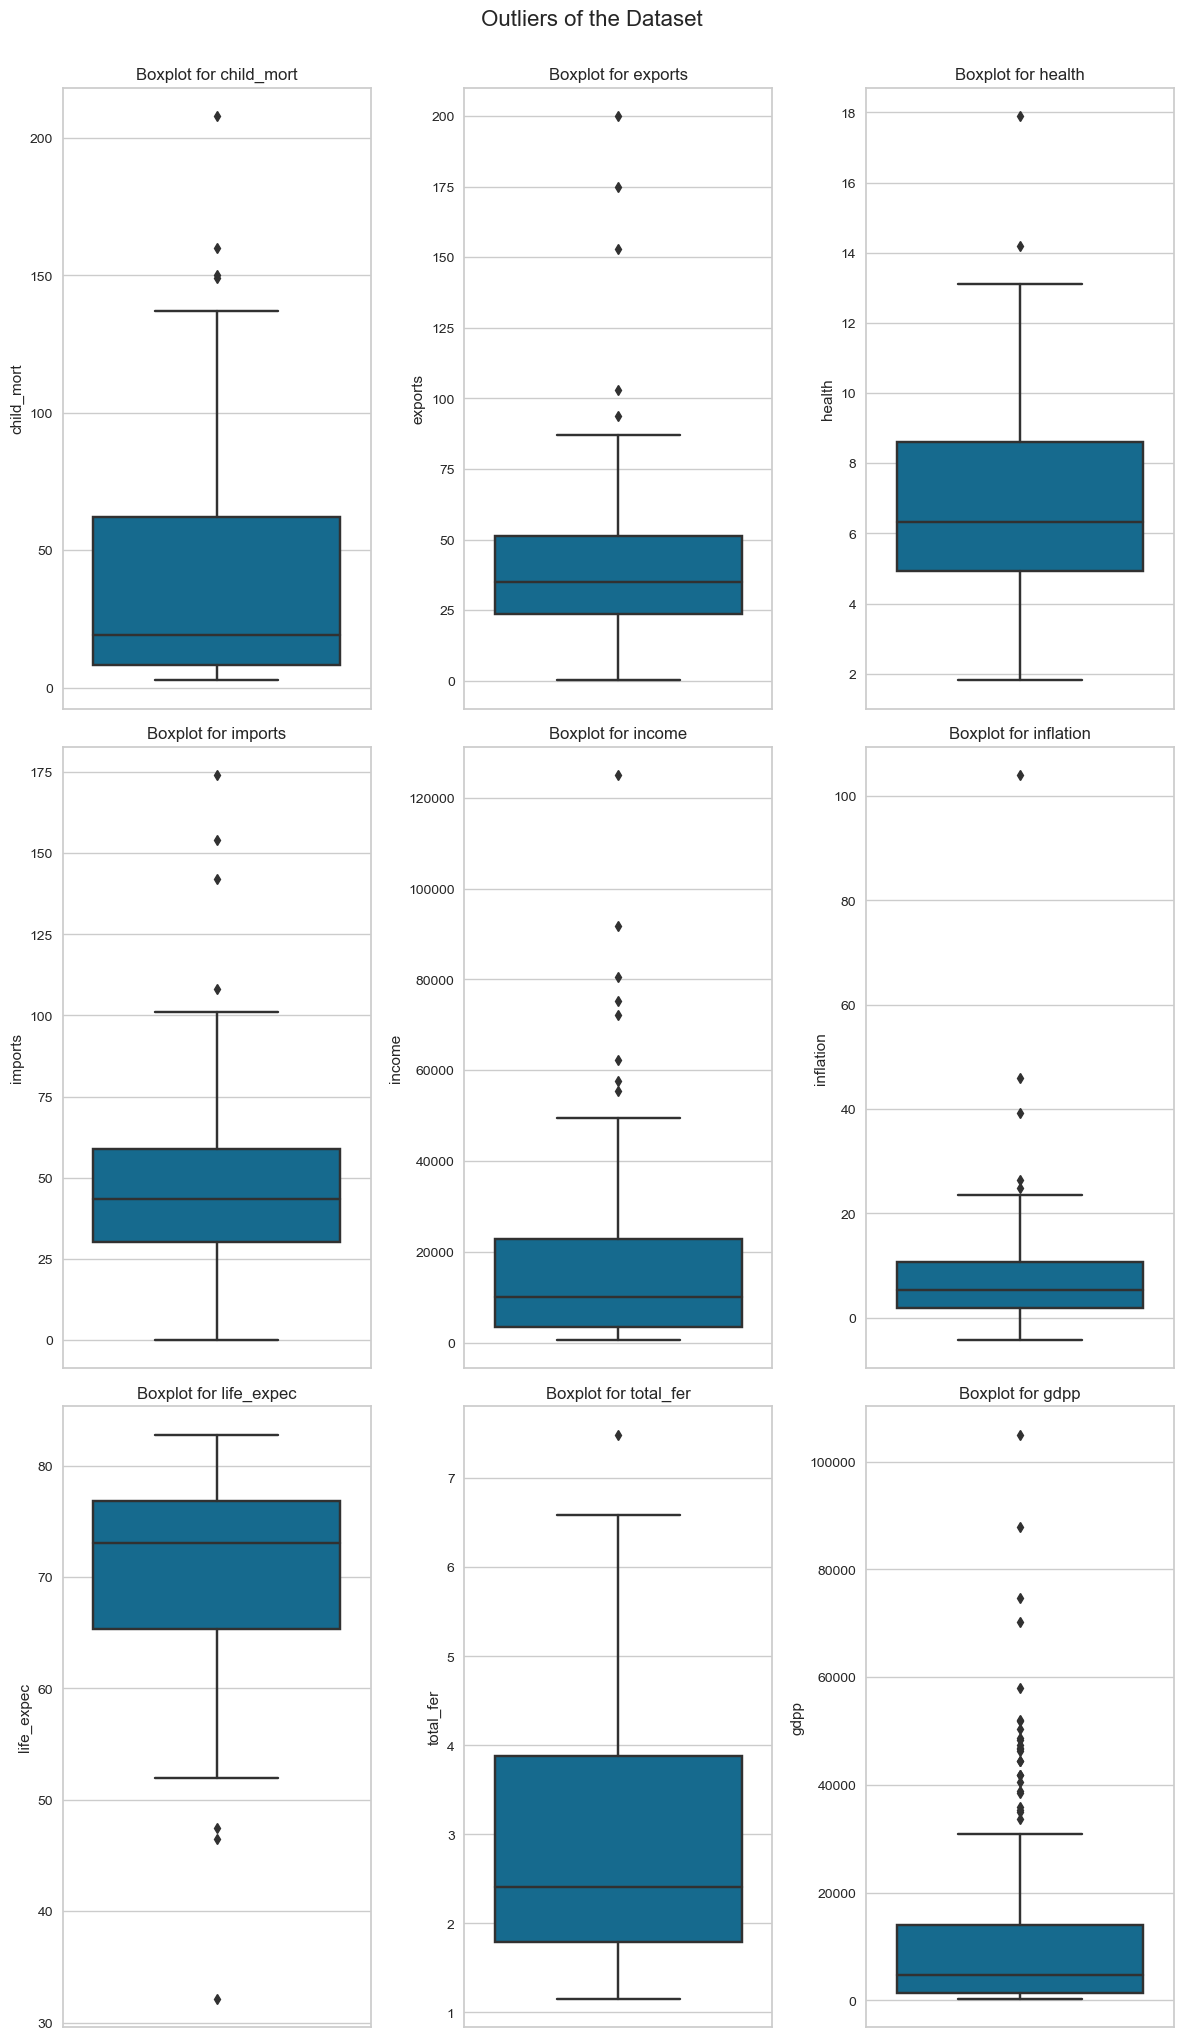

In [9]:

# Kích thước của figure
plt.figure(figsize=(12, 20))

# Vẽ boxplot cho tất cả các cột
for i, column in enumerate(df.columns[1:], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot for {column}')

plt.tight_layout()
plt.suptitle("Outliers of the Dataset", y=1.02, fontsize=16)
plt.show()

2.3.2 Xử lý giá trị ngoại lệ

⭐ Hàm xử lý giá trị ngoại lệ

In [10]:
def iqr(df, var):
    q1 = np.quantile(df[var], 0.25)
    q3 = np.quantile(df[var], 0.75)
    diff = q3 - q1
    lower_v = q1 - (1.5 * diff)
    upper_v = q3 + (1.5 * diff)
    return df[(df[var] < lower_v) | (df[var] > upper_v)]

⭐ Xử lý giá trị ngoại lệ cột child_mort

In [11]:
# Giá trị trung bình
iqr(df, 'child_mort')['child_mort']

31     149.0
32     150.0
66     208.0
132    160.0
Name: child_mort, dtype: float64

In [12]:
# In ra giá trị ngoại lệ nhỏ nhất của cột
iqr(df, 'child_mort')['child_mort'].min()

149.0

In [13]:
# Tìm giá trị lớn nhất của cột (<172)
df[df['child_mort'] < 149].child_mort.max()

137.0

In [14]:
# Tính phần trăm winsorize cho giá trị 137 trong cột "child_mort"
winsorize_percentile_child_mort = (stats.percentileofscore(df['child_mort'], 137)) / 100

# In ra phần trăm winsorize
print(winsorize_percentile_child_mort)
child_mort_winsorize = winsorize(df.child_mort, (0, (1 - winsorize_percentile_child_mort)))

# Lưu giá trị ngoại lệ đã được xử lý vào cột
df['child_mort'] = child_mort_winsorize

0.9760479041916167


⭐ Xử lý giá trị ngoại lệ cột exports

In [15]:
outlier_min_exports = iqr(df, 'exports')['exports'].min()
df[df['exports'] < outlier_min_exports].exports.max()

86.9

In [16]:
winsorize_percentile_exports = (stats.percentileofscore(df['exports'], 86.9)) / 100

print(winsorize_percentile_exports)
exports_winsorize = winsorize(df.exports, (0, (1 - winsorize_percentile_exports)))

df['exports'] = exports_winsorize

0.9700598802395208


⭐ Xử lý giá trị ngoại lệ cột health

In [17]:
outlier_min_health = iqr(df, 'health')['health'].min()
df[df['health'] < outlier_min_health].health.max()

13.1

In [18]:
winsorize_percentile_health = (stats.percentileofscore(df['health'], 13.1)) / 100

print(winsorize_percentile_health)
health_winsorize = winsorize(df.health, (0, (1 - winsorize_percentile_health)))

df['health'] = health_winsorize

0.9880239520958082


⭐ Xử lý giá trị ngoại lệ cột imports

In [19]:
outlier_min_imports = iqr(df, 'imports')['imports'].min()
df[df['imports'] < outlier_min_imports].imports.max()

101.0

In [20]:
winsorize_percentile_imports = (stats.percentileofscore(df['imports'], 101)) / 100

print(winsorize_percentile_imports)
imports_winsorize = winsorize(df.imports, (0, (1 - winsorize_percentile_imports)))

df['imports'] = imports_winsorize

0.9760479041916167


⭐ Xử lý giá trị ngoại lệ cột income

In [21]:
outlier_min_income = iqr(df, 'income')['income'].min()
df[df['income'] < outlier_min_income].income.max()

49400

In [22]:
winsorize_percentile_income = (stats.percentileofscore(df['income'], 49400)) / 100

print(winsorize_percentile_income)
income_winsorize = winsorize(df.income, (0, (1 - winsorize_percentile_income)))

df['income'] = income_winsorize

0.9520958083832335


⭐ Xử lý giá trị ngoại lệ cột inflation

In [23]:
outlier_min_inflation = iqr(df, 'inflation')['inflation'].min()
df[df['inflation'] < outlier_min_inflation].inflation.max()

23.6

In [24]:
winsorize_percentile_inflation = (stats.percentileofscore(df['inflation'], 23.6)) / 100

print(winsorize_percentile_inflation)
inflation_winsorize = winsorize(df.inflation, (0, (1 - winsorize_percentile_inflation)))

df['inflation'] = income_winsorize

0.9700598802395208


⭐ Xử lý giá trị ngoại lệ cột life_expec

In [25]:
iqr(df, 'life_expec')['life_expec']

31    47.5
66    32.1
87    46.5
Name: life_expec, dtype: float64

In [26]:
outlier_min_life_expec = iqr(df, 'life_expec')['life_expec'].max()

df[df['life_expec'] > outlier_min_life_expec].life_expec.min()

52.0

In [27]:
df.at[31, 'life_expec'] = 52
df.at[66, 'life_expec'] = 52
df.at[87, 'life_expec'] = 52

⭐ Xử lý giá trị ngoại lệ cột total_fer

In [28]:
outlier_min_total_fer = iqr(df, 'total_fer')['total_fer'].min()
df[df['total_fer'] < outlier_min_total_fer].total_fer.max()

6.59

In [29]:
winsorize_percentile_total_fer = (stats.percentileofscore(df['total_fer'], 6.59)) / 100

print(winsorize_percentile_total_fer)
total_fer_winsorize = winsorize(df.total_fer, (0, (1 - winsorize_percentile_total_fer)))

df['total_fer'] = total_fer_winsorize

0.9940119760479041


⭐ Xử lý giá trị ngoại lệ cột gdpp

In [30]:
outlier_min_gdpp = iqr(df, 'gdpp')['gdpp'].min()
df[df['gdpp'] < outlier_min_gdpp].gdpp.max()

30800

In [31]:
winsorize_percentile_gdpp = (stats.percentileofscore(df['gdpp'], 30800)) / 100

print(winsorize_percentile_total_fer)
gdpp_winsorize = winsorize(df.gdpp, (0, (1 - winsorize_percentile_gdpp)))

df['gdpp'] = gdpp_winsorize

0.9940119760479041


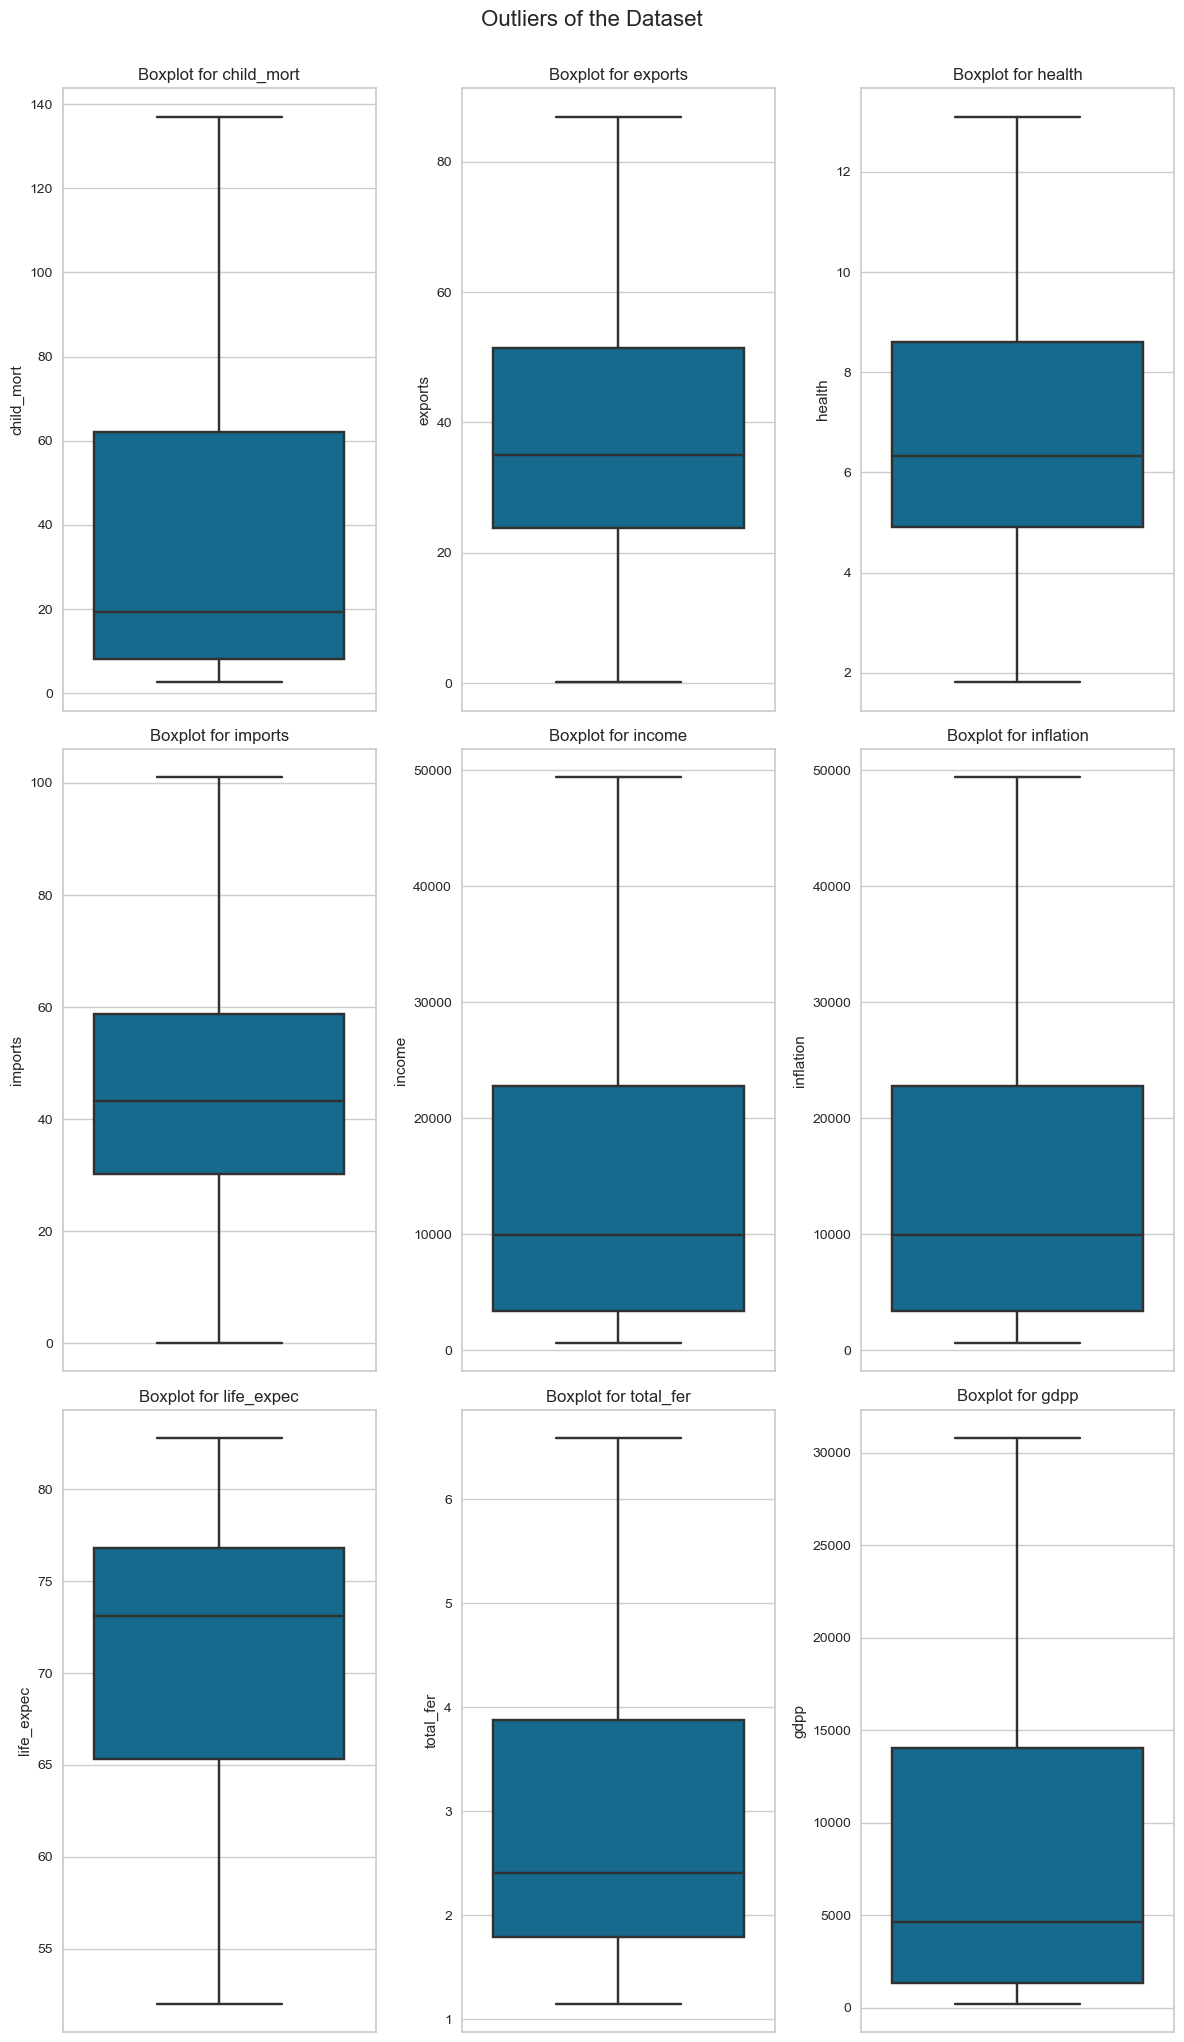

In [32]:

# Kích thước của figure
plt.figure(figsize=(12, 20))

# Vẽ boxplot cho tất cả các cột
for i, column in enumerate(df.columns[1:], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot for {column}')

plt.tight_layout()
plt.suptitle("Outliers of the Dataset", y=1.02, fontsize=16)
plt.show()

2.4 Lưu tập dữ liệu sau khi đã tiền xử lý

In [33]:
# df.to_csv('country_data_processed.csv', index=False)

# Phần 3: Mối tương quan của tập dữ liệu

3.1 Biểu đồ thể hiện 50 quốc gia có tỉ lệ child_mort cao nhất theo thứ tự giảm dần

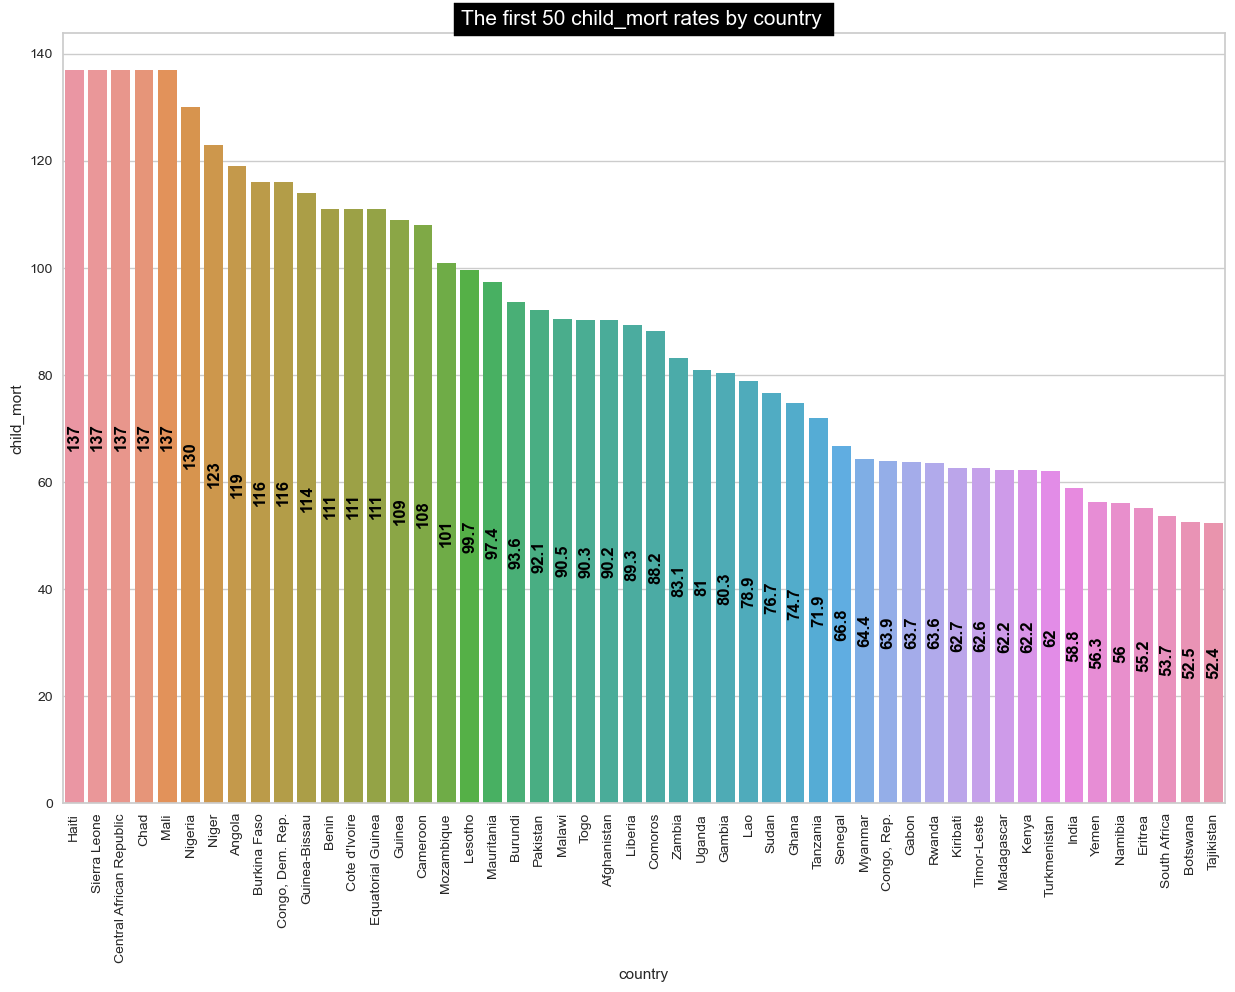

In [34]:
plt.figure(figsize=(15,10)) #size
plt.title('The first 50 child_mort rates by country ',backgroundcolor = 'Black', color='white',fontsize=15) #title 
ax = sns.barplot(x = 'country',y = 'child_mort', data = df.sort_values(ascending = False,by = 'child_mort').iloc[:50]);
plt.xticks(rotation=90) # ticks
for i in ax.containers:
    i.datavalues
    ax.bar_label(i,fontweight='bold',color='black',label_type='center', rotation=90)
plt.show()

3.2 Biểu đồ phân phối các trường trên tập dữ liệu

In [35]:
df2 = df.copy()

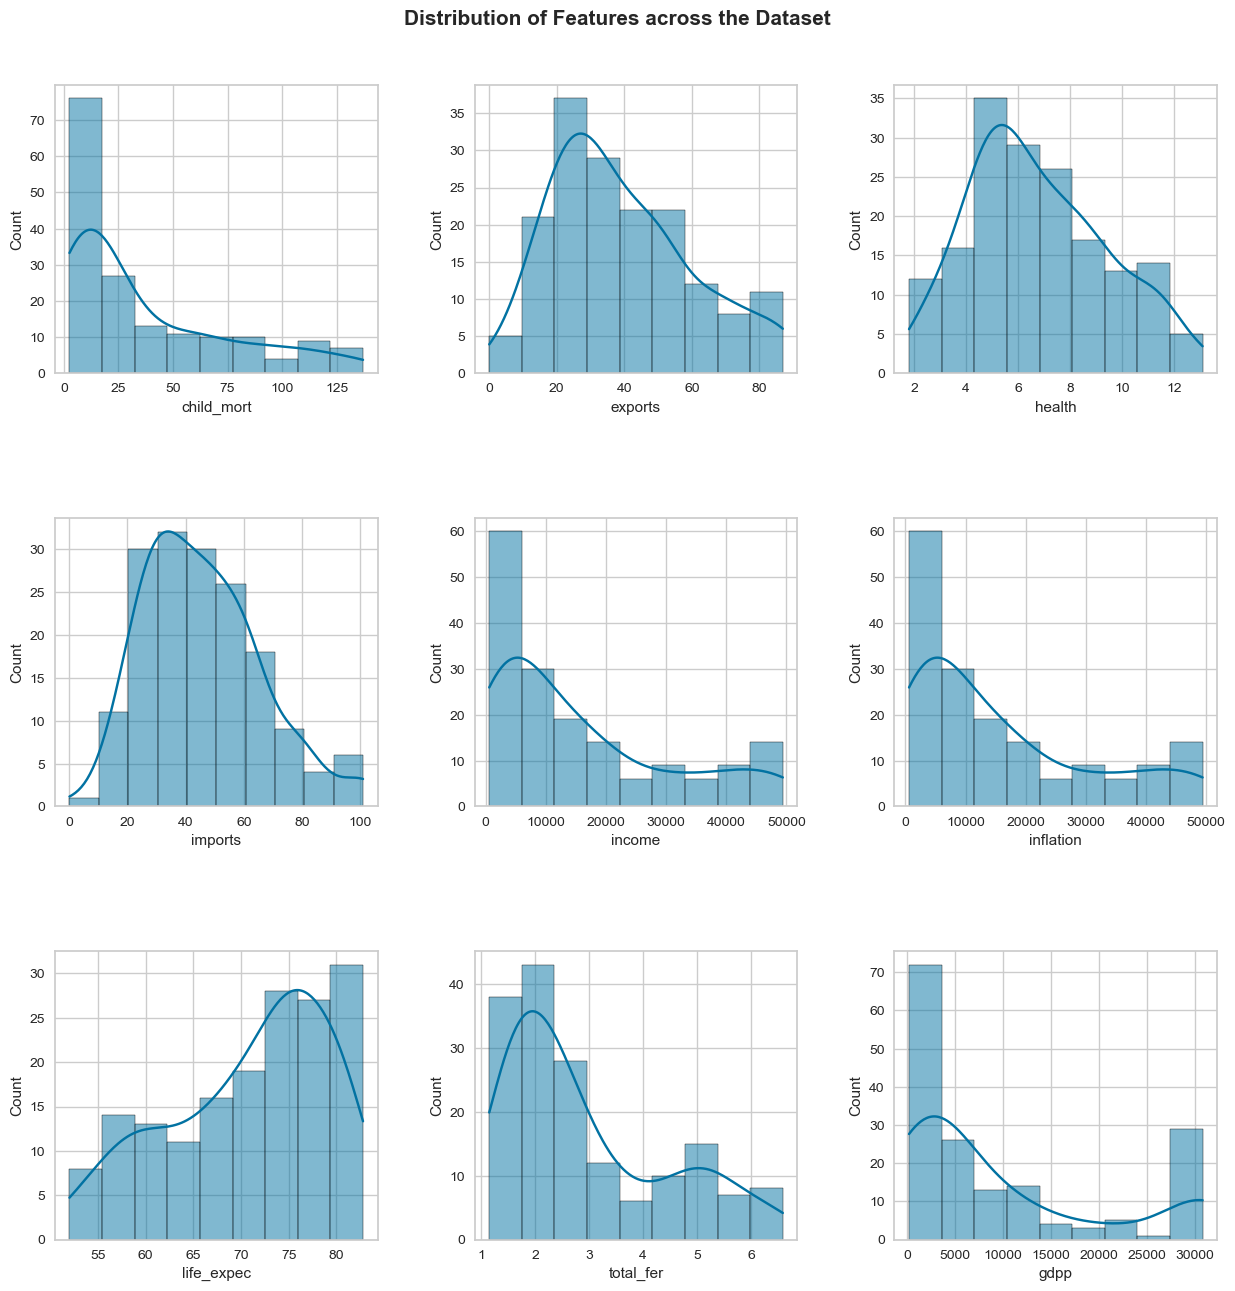

In [36]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15), gridspec_kw={"hspace": 0.5, "wspace": 0.3})
for i, col in enumerate(df2.drop(columns='country')):
    sns.histplot(df[col], kde=True, ax=ax[i//3, i%3])
    
fig.suptitle('Distribution of Features across the Dataset', fontsize=15, fontweight='bold', y=0.93)
plt.show()

3.3 Biểu đồ thể hiện mức độ tương quan của toàn bộ tập dữ liệu

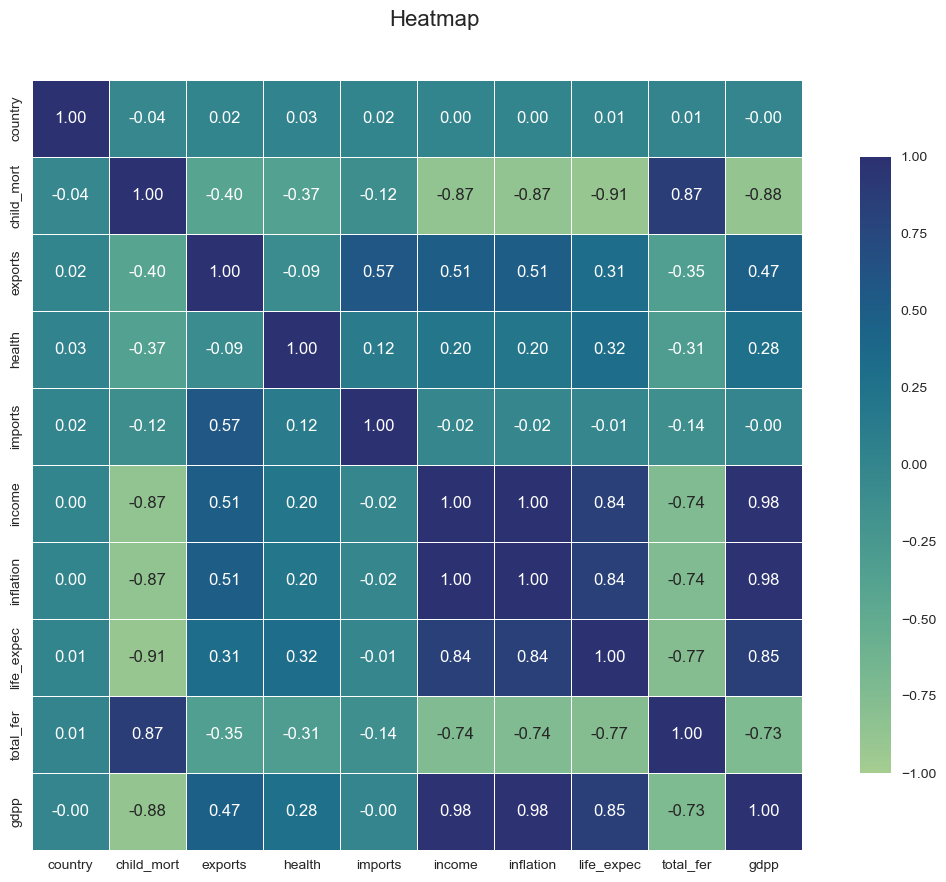

In [37]:
from sklearn.preprocessing import LabelEncoder
df_encoded = df.copy()

# Sử dụng LabelEncoder để chuyển đổi cột "country" thành dữ liệu số
label_encoder = LabelEncoder()
df_encoded['country'] = label_encoder.fit_transform(df['country'])

# Tạo heatmap cho ma trận tương quan
plt.figure(figsize=(15, 10))
sns.heatmap(df_encoded.corr(method='spearman', min_periods=1), annot=True, cmap="crest", linewidths=.5, fmt=".2f", vmin=-1, vmax=1, center=0, square=True, cbar_kws={"shrink": 0.8})

plt.suptitle("Heatmap", y=0.95, fontsize=16)  # Thêm tiêu đề chung
plt.show()

# Phần 4. Mô hình

# K-Means

In [38]:
df_km = df.drop('country', axis=1)

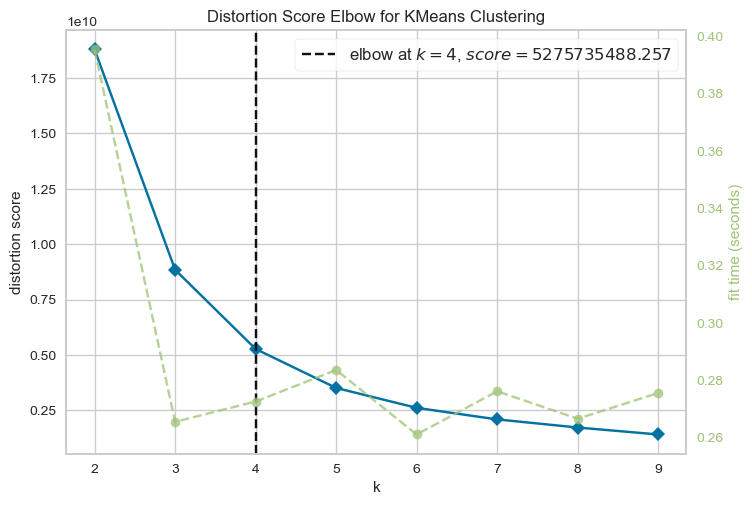

In [39]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(df_km)
visualizer.show()
plt.show()

In [40]:
number_of_clusters = 4
kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', random_state=42)
y_kmeans_pred = kmeans.fit_predict(df_km)

In [41]:
# Dữ liệu và thuật toán KMeans
kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++')

start_time = time.time()

# Thực hiện clustering và lấy nhãn
labels = kmeans.fit_predict(df_km)

end_time = time.time()

# Đánh giá chất lượng mô hình bằng Silhouette Score
silhouette_avg = silhouette_score(df_km, labels)

# In thông tin
print(f'Thời gian chạy: {end_time - start_time:.4f} giây')
print(f'Độ chính xác: {silhouette_avg:.4f}')

Thời gian chạy: 0.2865 giây
Độ chính xác: 0.6044


In [42]:
df_km = df.drop(['country'], axis =1)
selected_components = df_km.select_dtypes(include=['int64', 'float64'])

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(selected_components)

# Thêm nhãn cụm vào dataset
df_km['Cluster'] = clusters

⭐ inflation - income: 1

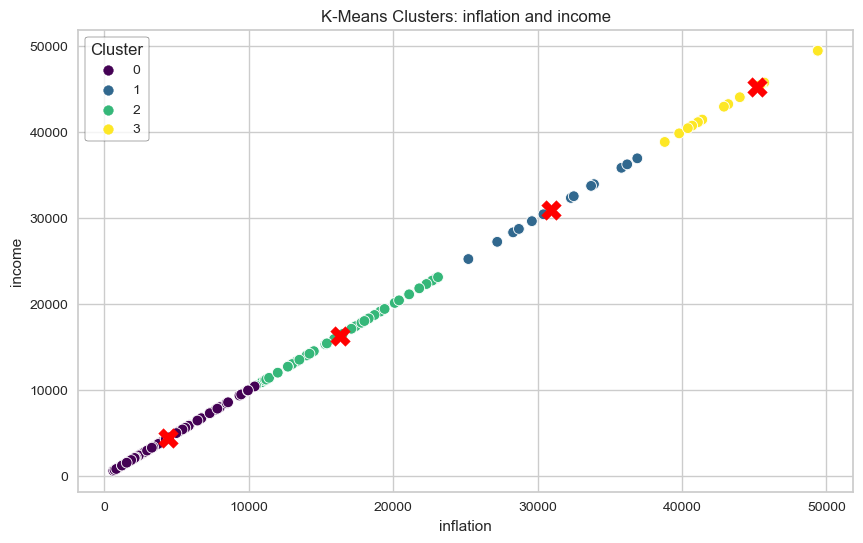

In [43]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=df_km["inflation"], y=df_km["income"], hue=clusters, palette='viridis', s=60)

for cluster_label in df_km['Cluster'].unique():
    cluster_center = df_km[df_km['Cluster'] == cluster_label][['inflation', 'income']].mean()
    plt.scatter(cluster_center['inflation'], cluster_center['income'], s=200, c='red', marker='X')

plt.title('K-Means Clusters: inflation and income')
plt.xlabel('inflation')
plt.ylabel('income')
plt.legend(title='Cluster', frameon=True, edgecolor='black')

plt.show()

⭐ gdpp - income: 0.98

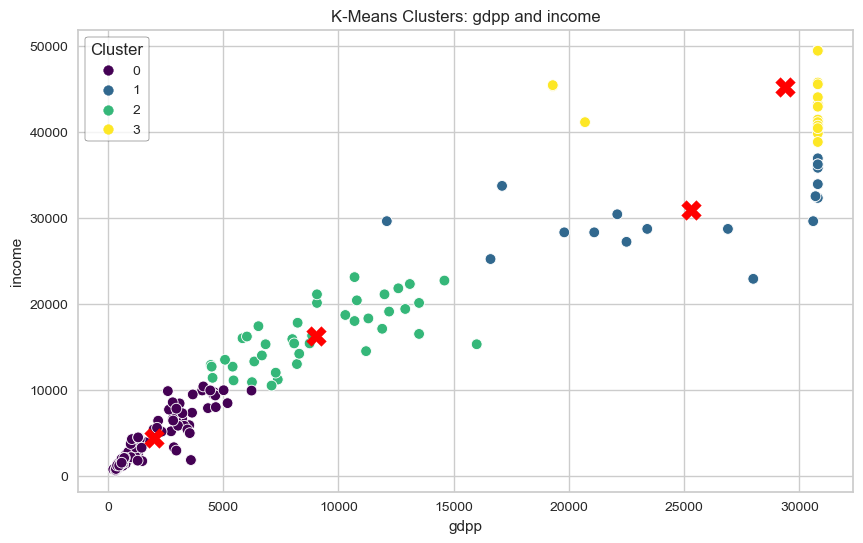

In [44]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=df_km["gdpp"], y=df_km["income"], hue=clusters, palette='viridis', s=60)

for cluster_label in df_km['Cluster'].unique():
    cluster_center = df_km[df_km['Cluster'] == cluster_label][['gdpp', 'income']].mean()
    plt.scatter(cluster_center['gdpp'], cluster_center['income'], s=200, c='red', marker='X')

plt.title('K-Means Clusters: gdpp and income')
plt.xlabel('gdpp')
plt.ylabel('income')
plt.legend(title='Cluster', frameon=True, edgecolor='black')

plt.show()

# Hierarchical Clustering

In [45]:
#scaling data
scaling=StandardScaler()
scaled=scaling.fit_transform(df_km)
scaled_df=pd.DataFrame(scaled,columns=df_km.columns)

Text(0.5, 1.0, 'Hierarchical Clustering')

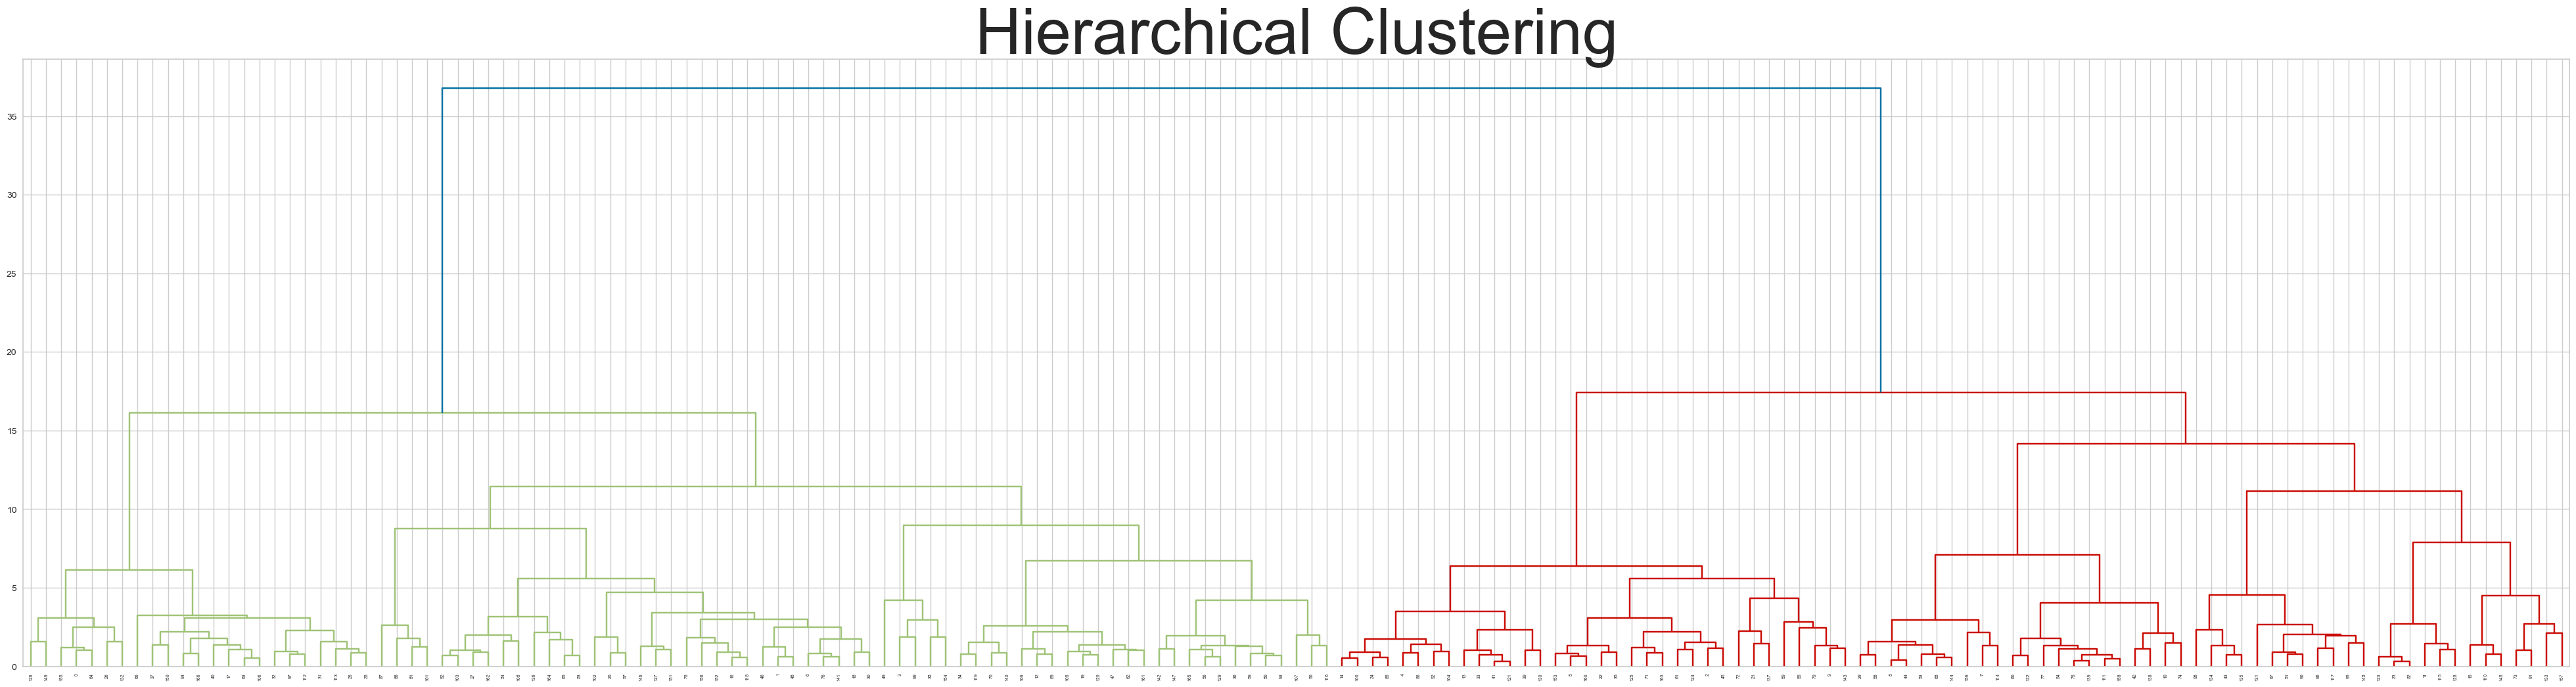

In [46]:
plt.figure(figsize=(50, 12))
dend=hcluster.dendrogram(hcluster.linkage(scaled_df,method='ward'))
plt.title("Hierarchical Clustering", fontsize=70)

In [47]:
# Timing the clustering process
start_time = time.time()

# Hierarchical clustering
hcluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
hcluster_label = hcluster.fit_predict(scaled_df)

# Calculate silhouette score
silhouette_avg = silhouette_score(scaled_df, hcluster_label)

# Timing information
end_time = time.time()

# Adding cluster labels to the original dataframe
hcluster_df = pd.DataFrame(df_km)
hcluster_df['hcluster'] = hcluster_label

# Print information
print(f'Thời gian chạy: {end_time - start_time:.4f} giây')
print(f'Silhouette Score: {silhouette_avg:.4f}')


Thời gian chạy: 0.0080 giây
Silhouette Score: 0.2007


In [48]:
hcluster_df = pd.DataFrame(df_km)
# thêm nhãn hcluster trong hcluster_df
hcluster_df['hcluster'] = hcluster_label

In [49]:
hcluster_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster,hcluster
0,90.2,10.0,7.58,44.9,1610,1610,56.2,5.82,553,0,3
1,16.6,28.0,6.55,48.6,9930,9930,76.3,1.65,4090,0,1
2,27.3,38.4,4.17,31.4,12900,12900,76.5,2.89,4460,2,2
3,119.0,62.3,2.85,42.9,5900,5900,60.1,6.16,3530,0,1
4,10.3,45.5,6.03,58.9,19100,19100,76.8,2.13,12200,2,2


⭐ inflation - income: 1

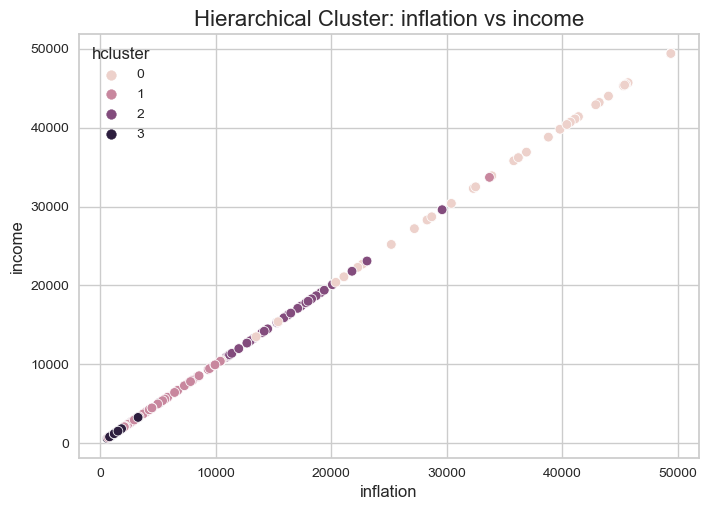

In [50]:
sns.scatterplot(x=hcluster_df['inflation'], y=hcluster_df['income'], hue='hcluster', data=hcluster_df)
plt.title("Hierarchical Cluster: inflation vs income", fontsize=16)
plt.xlabel("inflation", fontsize=12)
plt.ylabel("income", fontsize=12)
plt.show()

⭐ gdpp - income: 0.98

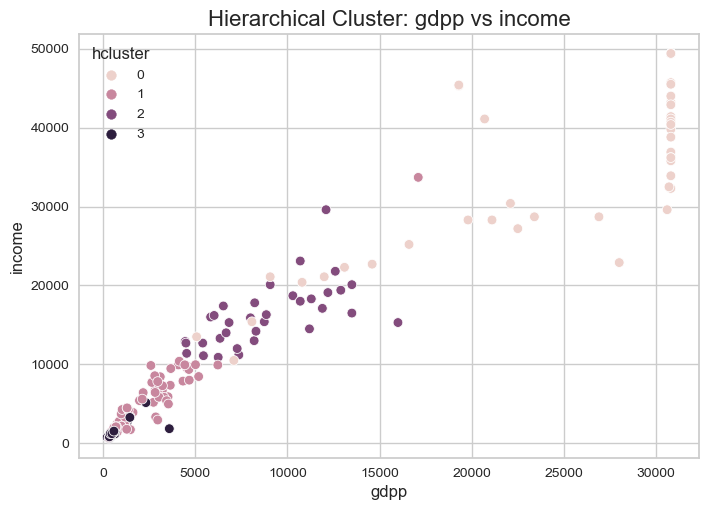

In [51]:
sns.scatterplot(x=hcluster_df['gdpp'],y=hcluster_df['income'],hue='hcluster',data=hcluster_df)
plt.title("Hierarchical Cluster: gdpp vs income", fontsize=16)
plt.xlabel("gdpp", fontsize=12)
plt.ylabel("income", fontsize=12)
plt.show()

# DBSCAN

Thời gian chạy: 0.0044765472412109375 giây
Điểm Silhouette: 0.2677


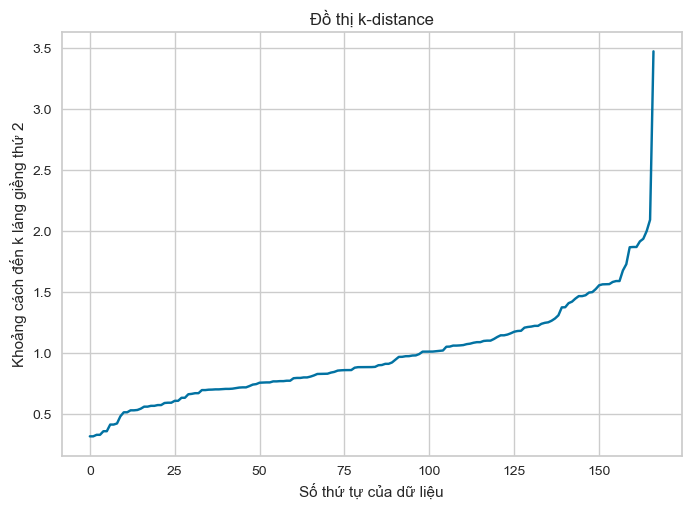

In [52]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
df_km_scaled = scaler.fit_transform(df_km)

# Sử dụng Nearest Neighbors để tính toán khoảng cách
neighbors = NearestNeighbors(n_neighbors=2)

# Bắt đầu đo thời gian
start_time = time.time()

# Fit dữ liệu
neighbors_fit = neighbors.fit(df_km_scaled)

# Tính toán khoảng cách và chỉ số của hàng gần nhất
distances, indices = neighbors_fit.kneighbors(df_km_scaled)

# Kết thúc đo thời gian
end_time = time.time()

# In thời gian chạy
print("Thời gian chạy:", end_time - start_time, "giây")

# Sử dụng chỉ số hàng gần nhất để thực hiện DBSCAN
dbscan = DBSCAN(eps=2.0, min_samples=10)
dbscan_labels = dbscan.fit_predict(df_km_scaled)

# Tính toán điểm Silhouette
silhouette = silhouette_score(df_km_scaled, dbscan_labels)

# In điểm Silhouette
print(f"Điểm Silhouette: {silhouette:.4f}")

# Sắp xếp và vẽ đồ thị để xem độ dốc của đồ thị
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.xlabel('Số thứ tự của dữ liệu')
plt.ylabel('Khoảng cách đến k láng giềng thứ 2')
plt.title('Đồ thị k-distance')
plt.show()

eps=0.5, min_samples=3: Silhouette Score = 0.07475704979029331
eps=1.0, min_samples=3: Silhouette Score = -0.026483821124815767
eps=1.0, min_samples=5: Silhouette Score = -0.1087226581489152
eps=1.0, min_samples=7: Silhouette Score = -0.2040150397976312
eps=1.5, min_samples=3: Silhouette Score = 0.19519880809316822
eps=1.5, min_samples=5: Silhouette Score = 0.19955183994382367
eps=1.5, min_samples=7: Silhouette Score = 0.17550501331375076
eps=1.5, min_samples=10: Silhouette Score = 0.1283321122091682
eps=2.0, min_samples=3: Silhouette Score = 0.06538196457569197
eps=2.0, min_samples=5: Silhouette Score = 0.08208895017685716
eps=2.0, min_samples=7: Silhouette Score = 0.11063101208541633
eps=2.0, min_samples=10: Silhouette Score = 0.21219675524967432

Best Parameters: eps=2.0, min_samples=10


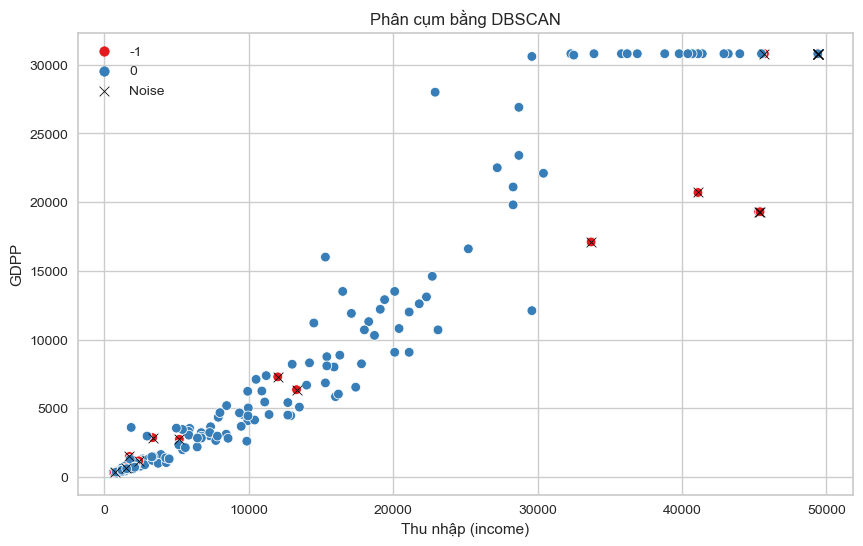

In [53]:
# Import thư viện cần thiết
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Thiết lập các giá trị eps và min_samples cần thử nghiệm
eps_values = [0.5, 1.0, 1.5, 2.0]
min_samples_values = [3, 5, 7, 10]

# Lưu trữ kết quả tốt nhất
best_eps = None
best_min_samples = None
best_silhouette_score = -1 

# Thử nghiệm với từng giá trị eps và min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Áp dụng thuật toán DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(scaled_df)

        # Kiểm tra số lượng cụm để tránh lỗi
        unique_labels = np.unique(labels)
        if len(unique_labels) > 1:
            # Tính silhouette score
            silhouette_avg = silhouette_score(scaled_df, labels)

            # In kết quả và kiểm tra xem có phải là tốt nhất không
            print(f"eps={eps}, min_samples={min_samples}: Silhouette Score = {silhouette_avg}")

            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples

# In ra thông tin về các tham số tốt nhất
print(f"\nBest Parameters: eps={best_eps}, min_samples={best_min_samples}")

# Áp dụng DBSCAN với các tham số tốt nhất
best_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
best_labels = best_dbscan.fit_predict(scaled_df)

noise_points = df_km[labels == -1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_km['income'], y=df_km['gdpp'], hue=labels, palette='Set1')
sns.scatterplot(x=noise_points['income'], y=noise_points['gdpp'], color='black', marker='x', label='Noise')
plt.xlabel('Thu nhập (income)')
plt.ylabel('GDPP')
plt.title('Phân cụm bằng DBSCAN')
plt.legend()
plt.show()